In [143]:
!pip install ucimlrepo

In [144]:
def prior_plots(prior_trace, crop_model, title=""):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    sns.histplot(prior_trace.prior['beta'].values.flatten(), bins=20, ax=axes[0, 0])
    axes[0, 0].set_title('Histograma de Beta')

    sns.histplot(prior_trace.prior_predictive['likelihood'].values.flatten(), bins=20, ax=axes[0, 1])
    axes[0, 1].set_title('Histograma de Likelihood')

    az.plot_ppc(prior_trace, group='prior', kind='cumulative', ax=axes[1, 0], observed="likelihood")
    axes[1, 0].set_title('Plot de PPC (Cumulativo)')

    az.plot_ppc(prior_trace, group='prior', ax=axes[1, 1], observed="likelihood")

    plt.tight_layout()
    pm.model_to_graphviz(crop_model)
    plt.suptitle('Análise de Priors e PPC' + title, fontsize=16)

    plt.show()


In [145]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

In [146]:
df = fetch_ucirepo(id=9).data.original

In [147]:
encoder = LabelEncoder()
df["car_name"] = encoder.fit_transform(df["car_name"])

normalizer = StandardScaler()
X = normalizer.fit_transform(df.drop(["mpg","car_name"], axis=1))
y = df["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
X_train = np.nan_to_num(X_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)

In [149]:
#todos terão o mesmo
coords = {
    "features": df.drop(["mpg","car_name"], axis=1).columns
}

# Modelo de Ridge


In [150]:
with pm.Model(coords=coords) as ridge:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, dims="features")

    X = pm.Data("X", X_train)
    y = pm.Data("y",y_train)

    mu = pm.math.dot(X, beta)
    eps = pm.Exponential("eps", 1)

    likelihood = pm.Normal("likelihood", mu=mu, sigma=eps, observed=y)

    prior_predictive_ridge = pm.sample_prior_predictive(samples=1000)

RIDGE


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


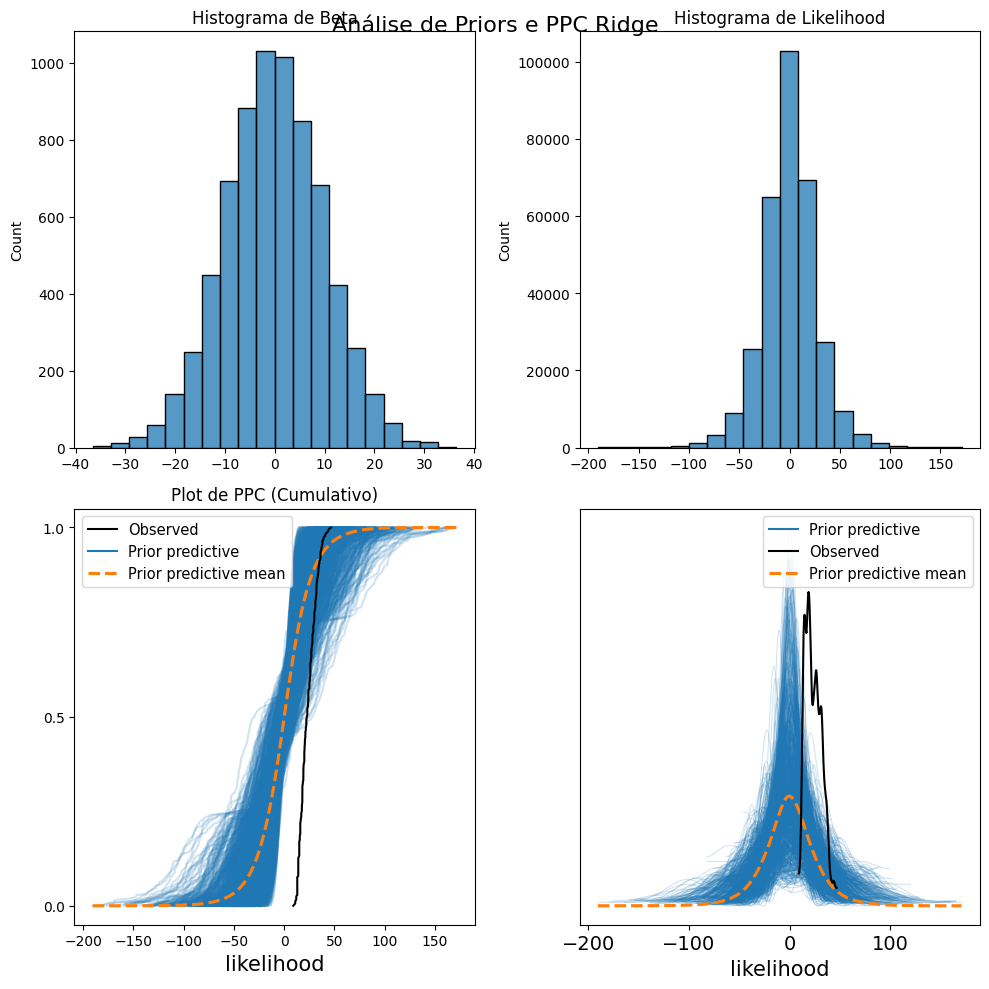

In [151]:
print("RIDGE")
prior_plots(prior_predictive_ridge,ridge," Ridge")

Por increvel que pareça as priores com valores mu e sigma sendo, respectivamente 0 e 10 foram os melhores

In [152]:
with ridge:
    ridge_trace = pm.sample(1000)

Output()

Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

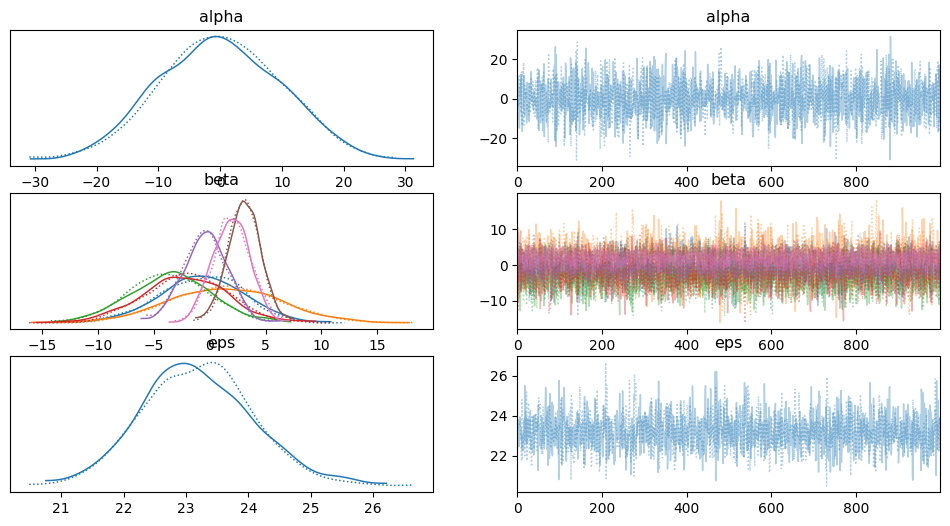

In [153]:
az.plot_trace(ridge_trace, var_names=["alpha", "beta","eps"])

In [154]:
print(pm.summary(ridge_trace))

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                0.054  9.686 -17.618   18.117      0.185    0.220   
beta[cylinders]     -0.764  3.753  -8.098    6.127      0.089    0.076   
beta[displacement]   1.324  4.948  -8.051   10.519      0.127    0.107   
beta[horsepower]    -3.615  3.614 -10.806    2.749      0.089    0.064   
beta[weight]        -2.171  3.769  -9.349    4.655      0.103    0.080   
beta[acceleration]  -0.408  1.964  -4.171    3.127      0.047    0.040   
beta[model_year]     3.085  1.455   0.333    5.819      0.030    0.022   
beta[origin]         1.961  1.669  -1.432    4.787      0.032    0.026   
eps                 23.193  0.889  21.601   24.931      0.019    0.014   

                    ess_bulk  ess_tail  r_hat  
alpha                 2758.0    1648.0    1.0  
beta[cylinders]       1804.0    1533.0    1.0  
beta[displacement]    1510.0    1427.0    1.0  
beta[horsepower]      1659.0    1491.0    1.0  
beta[weight]       

In [155]:
with ridge:
    pm.set_data({"X": X_test, "y": y_test})
    ridge_posterior = pm.sample_posterior_predictive(ridge_trace)

Output()

array([<Axes: xlabel='likelihood'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


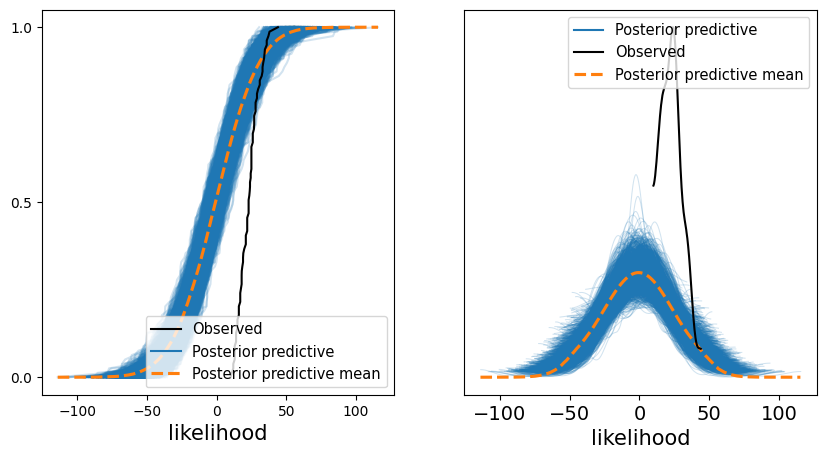

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(ridge_posterior, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(ridge_posterior, group='posterior', ax=axes[1])

Aparenta ter sido não muito bom

# Lasso

In [157]:
with pm.Model(coords=coords) as lasso:
    alpha = pm.Normal("alpha",0,1)
    beta = pm.Laplace("beta",0,1,dims="features")

    X = pm.Data("X",X_train)
    y = pm.Data("y",y_train)

    mu = pm.math.dot(X,beta)
    eps = pm.Exponential("eps",1)

    likelihood = pm.Normal("likelihood",mu=mu,sigma=eps,observed=y)
    prior_predictive_lasso = pm.sample_prior_predictive(samples=1000)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


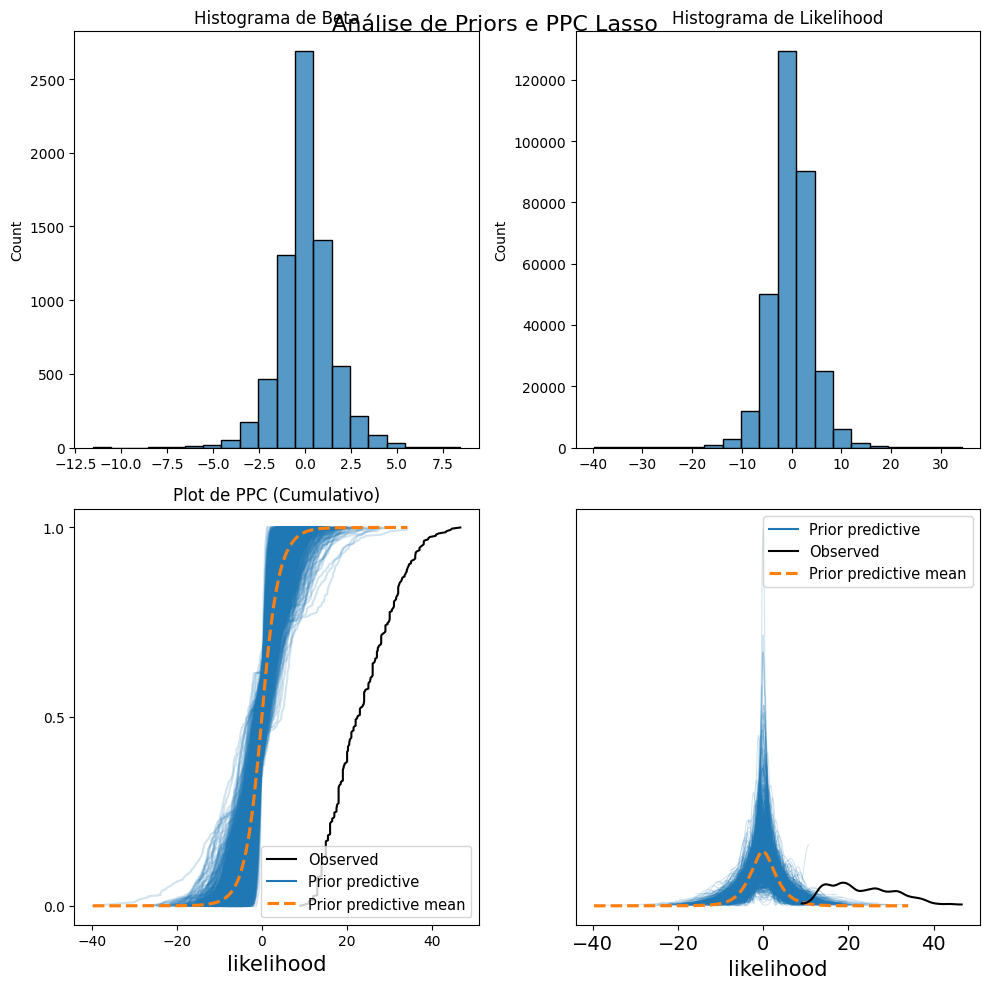

In [158]:
prior_plots(prior_predictive_lasso,lasso," Lasso")

In [159]:
with lasso:
    lasso_trace = pm.sample(1000)

Output()

Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

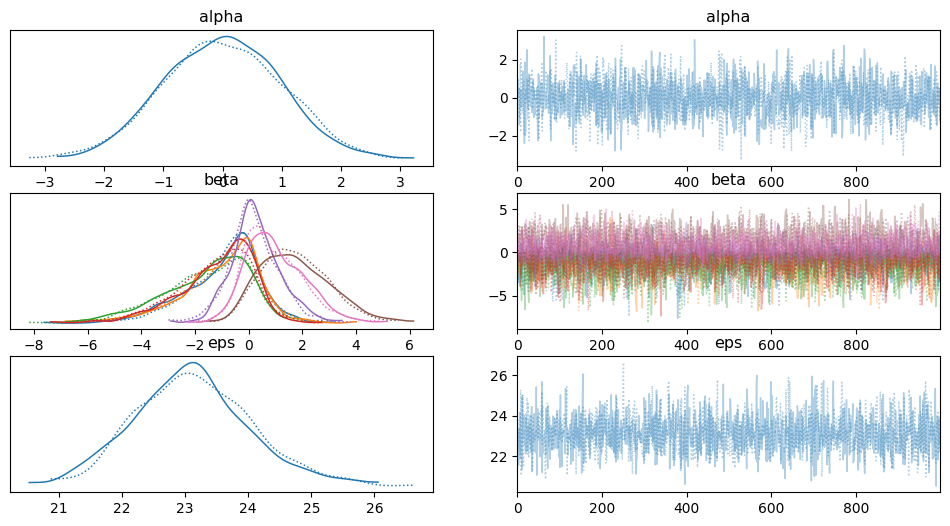

In [160]:
az.plot_trace(lasso_trace, var_names=["alpha", "beta","eps"])

In [161]:
print(pm.summary(lasso_trace))

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha               -0.008  0.997  -1.884    1.822      0.022    0.024   
beta[cylinders]     -0.968  1.402  -3.811    1.418      0.045    0.038   
beta[displacement]  -1.072  1.500  -4.053    1.565      0.050    0.042   
beta[horsepower]    -1.581  1.588  -4.676    1.006      0.045    0.034   
beta[weight]        -1.234  1.383  -4.196    0.712      0.045    0.036   
beta[acceleration]   0.223  0.925  -1.534    1.977      0.023    0.023   
beta[model_year]     1.722  1.266  -0.421    4.101      0.034    0.026   
beta[origin]         0.947  1.095  -0.852    3.116      0.029    0.024   
eps                 23.119  0.915  21.564   25.048      0.020    0.014   

                    ess_bulk  ess_tail  r_hat  
alpha                 2007.0    1355.0    1.0  
beta[cylinders]       1218.0     813.0    1.0  
beta[displacement]    1111.0     747.0    1.0  
beta[horsepower]      1354.0    1278.0    1.0  
beta[weight]       

In [162]:
with lasso:
    pm.set_data({"X": X_test, "y": y_test})
    lasso_posterior = pm.sample_posterior_predictive(lasso_trace)

Output()

<Axes: xlabel='likelihood'>

<Figure size 1000x500 with 0 Axes>

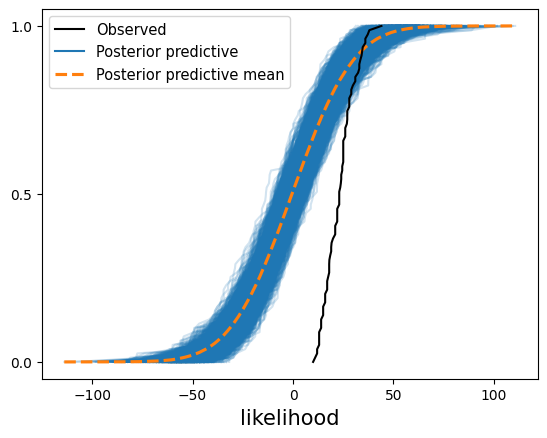

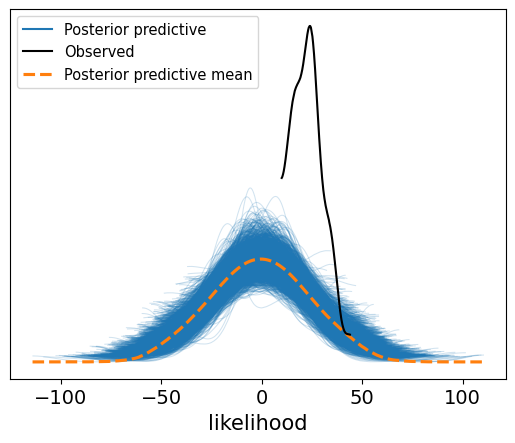

In [163]:
plt.figure(figsize=(10, 5))
az.plot_ppc(lasso_posterior, group='posterior', kind='cumulative')
az.plot_ppc(lasso_posterior, group='posterior')

# Robusta

In [164]:
with pm.Model(coords = coords) as robust:
    alpha = pm.Normal("alpha",0,1)
    beta = pm.Normal("beta",0,1,dims="features")

    X = pm.Data("X",X_train)
    y = pm.Data("y",y_train)

    mu = pm.math.dot(X,beta)
    dof = pm.Exponential("dof",1)

    likelihood = pm.StudentT("likelihood",mu=mu,sigma=1,nu=dof,observed=y)
    prior_predictive_robust = pm.sample_prior_predictive(samples=1000)

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
<ipython-input-144-d02ad7879c98>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


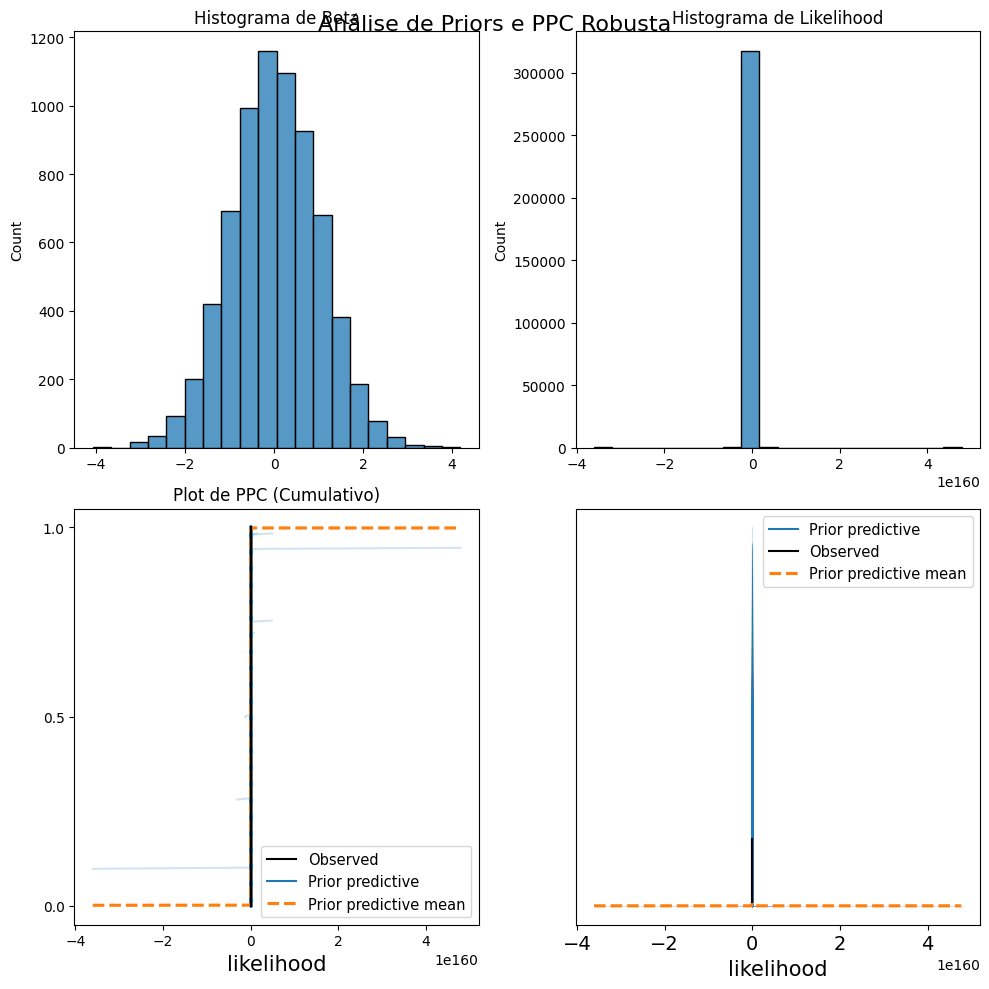

In [165]:
prior_plots(prior_predictive_robust,robust," Robusta")

não sei bem o que tira disso

In [166]:
with robust:
    robust_trace = pm.sample(1000)

Output()

Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'dof'}>, <Axes: title={'center': 'dof'}>]],
      dtype=object)

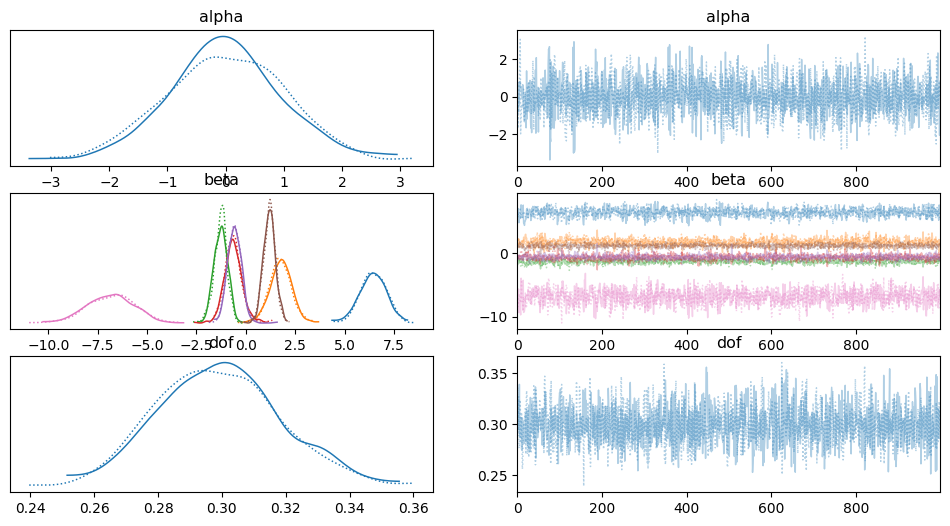

In [167]:
az.plot_trace(robust_trace, var_names=["alpha", "beta","dof"])

In [168]:
with robust:
    pm.set_data({"X": X_test, "y": y_test})
    robust_posterior = pm.sample_posterior_predictive(robust_trace)

Output()

<Axes: xlabel='likelihood'>

<Figure size 1000x500 with 0 Axes>

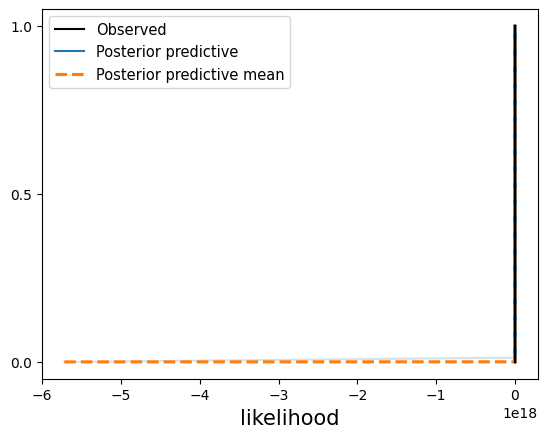

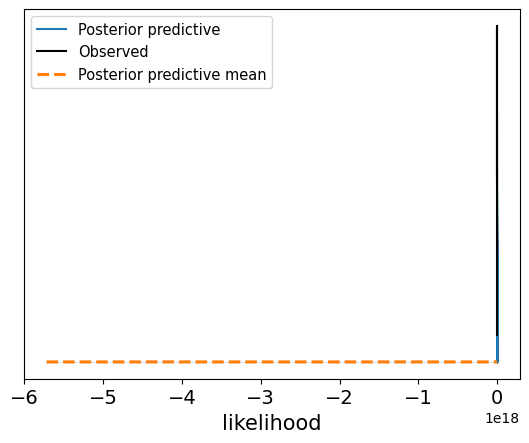

In [169]:
plt.figure(figsize=(10, 5))
az.plot_ppc(robust_posterior, group='posterior', kind='cumulative')
az.plot_ppc(robust_posterior, group='posterior')

# Comparação dos modelos

In [170]:
with ridge:
    pm.compute_log_likelihood(ridge_trace)

with lasso:
    pm.compute_log_likelihood(lasso_trace)

with robust:
    pm.compute_log_likelihood(robust_trace)


Output()

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

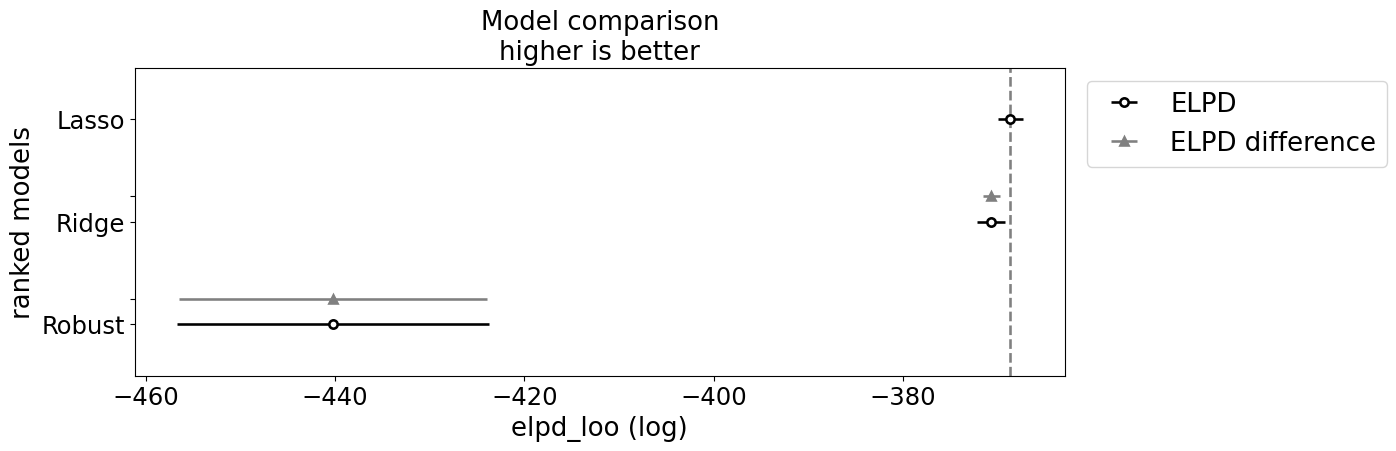

In [171]:
model_compare = az.compare(
    {
        "Ridge": ridge_trace,
        "Lasso": lasso_trace,
        "Robust": robust_trace
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

Como mostra o ELPD, o modelo de Lasso foi o melhor, com os outros dois tendo práticamente o mesmo resultado

In [174]:
from sklearn.metrics import mean_squared_error

y_pred = lasso_posterior.posterior_predictive['likelihood'].mean(["chain","draw"]).to_numpy()
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 571.8298230101119


Conclusão: O modelo teve uma taixa de erro consideravelmente alta, mostrando que ainda falta robustes ou um cuidado maior com os parametros
